# Exploration

In [2]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch.nn as nn
import torch

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import seaborn as sns
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'keras'

In [2]:
# Load data
path_in = './data/'

train = pd.read_csv(path_in + 'train.csv')
test = pd.read_csv(path_in + 'test.csv')

Data structure: Question ID (qid), question text, target.

Target 0 - Negative

Target 1 - Positive

Training data:

Around 1,300,000 samples. Will have to be split up into training, validation and testing.

In [3]:
## Train data
print('Number of samples for training: {}\nRatio positives to total: {:.2f}'.format(len(train), 
                                                                                len(train.loc[train['target'] == 1])/len(train)))

Number of samples for training: 1306122
Ratio positives to total: 0.06


In [4]:
# That's a lot of questions, so for faster iterations, I'm going to just use 50,000 training examples
train = train.iloc[0:50000]
print('Number of samples for training: {}\nRatio positives to total: {:.2f}%'.format(len(train), 
                                                                                len(train.loc[train['target'] == 1])/len(train)*100))

Number of samples for training: 50000
Ratio positives to total: 6.22%


In [5]:
## Example sentence
train['question_text'][3]

'How did Otto von Guericke used the Magdeburg hemispheres?'

In [6]:
print(train['target'][3])
print(train['qid'][3])

0
000042bf85aa498cd78e


# Preprocessing

Currently, the questions are all in words that a computer will have problems handling. We have to first process the questions by tokenizing them. For example "One fish, two fish, red fish blue fish" -> [1 2 3 2 4 2 5 2]. The 0th token is normally reserved as a blank placeholder.

In [7]:
# Build the tokenizer dictionary in the tokenizer class
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['question_text'])
tokenizer.fit_on_texts(test['question_text'])

# Split train set into train and validation sets
train, validation = train_test_split(train, test_size=0.1, shuffle = True)

# Tokenize the questions
train_sequences = tokenizer.texts_to_sequences(train['question_text'])
validation_sequences = tokenizer.texts_to_sequences(validation['question_text'])
test_sequences = tokenizer.texts_to_sequences(test['question_text'])

# Save the tokenizer dictionary and the number of words in it
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [8]:
list_len_train = [len(i) for i in train_sequences]
list_len_validation = [len(i) for i in validation_sequences]
list_len_test = [len(i) for i in test_sequences]

print(max(list_len_train))
print(max(list_len_validation))
print(max(list_len_test))

63
54
240


The mean question length in the training set is 12.85 words.
The standard deviation of the question length in the training set is 7.04 words.


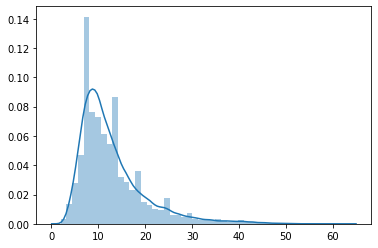

In [9]:
sns.distplot(list_len_train, kde = True)
print('The mean question length in the training set is {:.2f} words.'.format(np.mean(list_len_train)))
print('The standard deviation of the question length in the training set is {:.2f} words.'.format(np.std(list_len_train)))

As can be seen, the mean question length is 12.8 and a vast majority of the questions are under 30 words. I am therefore padding the sentences up to a length of 50 and truncating the rest

In [10]:
# Pad sequences with 0s so that each sequence is of the same length respresented by the max_length
max_length = 50
padding_type = 'pre'
trunc_type = 'pre'

train_sequences_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [11]:
# Convert data to tensors

training_dataset = torch.utils.data.TensorDataset(torch.LongTensor(np.array(train_sequences_padded)), torch.FloatTensor(np.array(train['target'])))
validation_dataset = torch.utils.data.TensorDataset(torch.LongTensor(np.array(validation_sequences_padded)), torch.FloatTensor(np.array(validation['target'])))

In [12]:
training_dataset[1]

(tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,    16,    11,
         11420,   225,  5179,    22,    18,  2128,  1404,    59,     8,   342]),
 tensor(0.))

## Embeddings
As a start, the 'glove.6B.50d' embedding is used.

Also, you can use 'torchtext.vocab.GloVe(name='840B', dim=300)' (see [torchtext package](https://torchtext.readthedocs.io/en/latest/vocab.html#vocab) )

In [13]:
def load_embeddings(embeddings_File, embeddings_dim):
    print('Loading word embeddings...')
    embeddings_index = {}
    with open(embeddings_File,'r', encoding = 'utf8') as f:
        for line in f:
            values = line.split();
            word = ''.join(values[:-1*embeddings_dim]);
            coefs = np.asarray(values[-1*embeddings_dim:], dtype='float32');
            embeddings_index[word] = coefs;

    embeddings_matrix = np.zeros((vocab_size+1, embeddings_dim));
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word);
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector;  
            
    print('Finished loading word embeddings. {:.0f} words loaded.'.format(len(embeddings_matrix)))
    return embeddings_matrix

In [14]:
embeddings_File = './data/embeddings/glove.840B.300d/glove.840B.300d.txt'
embeddings_dim = 300

embeddings_matrix = load_embeddings(embeddings_File, embeddings_dim)

Loading word embeddings...
Finished loading word embeddings. 119961 words loaded.


Todo:

Explore the data. Find for example the longest quora question.

Pad the data with empty or null words

Embed the data

Create an RNN network to train the data

Look at the results and iterate

In [82]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias,0)
        
class Net(nn.Module):
    def __init__(self, embedding_dim, seq_length, n_hidden_1, n_hidden_2, D_out, p=0.0):
        super().__init__()
        
        # Initialize word embeddings layer using weights
        weight = torch.FloatTensor(embeddings_matrix)
        self.seq_length = seq_length
        self.embeds = nn.Embedding.from_pretrained(weight)
        #self.embeds_dropout = nn.Dropout2d(p = 0.1)
        
        self.lstm1 = nn.LSTM(embedding_dim, n_hidden_1, bidirectional = False, batch_first = True)
        
        # self.maxpool2d = nn.AdaptiveMaxPool2d(output_size = (1,n_hidden_1*2))
        
        self.fc1 = nn.Linear(n_hidden_1, n_hidden_2)
        # self.drop1 = nn.Dropout(p=p)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_2, D_out)
        self.out_act = nn.Sigmoid()
        
    def forward(self, x):
        # Embedding layer
        embeds_out = self.embeds(x)
        #embeds_out = self.embeds_dropout(embeds_out)
        #print(embeds_out.size())
        
        # LSTM layer
        lstm_out, (h, c) = self.lstm1(embeds_out)
        #print(lstm_out.size())
        #max_pool_out = self.maxpool2d(lstm_out)
        #print(max_pool_out.size())
        
        
        
        # Fully connected layer
        
        # Using the output of the last neuron in the LSTM layer
        fc1_out = self.fc1(h)
        fc1_out = self.drop1(fc1_out)
        fc1_out = self.relu1(fc1_out)
        #print(fc1_out.size())
        
        # Output layer
        y = self.out_act(self.fc2(fc1_out))
        #print(y.size())
        
        # Squeeze to remove extra dimensions of size 1
        return torch.squeeze(y)
    


In [83]:
def train_model(data_set, model, criterion, train_loader, validation_loader, optimizer, epochs=10):
    model.train()
    loss_accuracy = {'training_loss':[], 'validation_accuracy':[], 'validation_precision':[], 'validation_recall':[]}
    
    for epoch in range(epochs):
        #clear_output(wait=True)
        print("Epoch {} / {}\n=============".format(epoch+1, epochs))
            

        
        train_correct = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            ## Forward pass
            yhat = model(x)
            ## Compute loss
            loss = criterion(yhat, y)
            ## Compute gradient in backward pass
            loss.backward()
            ## Update weights
            optimizer.step()
            
            yhat = np.where(yhat.detach().numpy() > 0.5, 1, 0)
            train_correct += (yhat == y.numpy()).sum()
            
            loss_accuracy['training_loss'].append(loss.item())
         
        ## Compute validation accuracy
        model.eval()
        correct = 0
        for x, y in validation_loader:
            yhat = net(x)           
            yhat = np.where(yhat.detach().numpy() > 0.5, 1, 0)
            correct = (yhat == y.detach().numpy()).sum()                        
            accuracy = 100 * (correct / validation_loader.batch_size)
            
        loss_accuracy['validation_accuracy'].append(accuracy)
        
        ## Print training loss and accuracy, and validation accuracy
        train_acc = 100 * train_correct / len(train_loader.dataset)
        print("Training loss: {} | Training accuracy: {:.2f}%\nValidation accuracy: {:.2f}%".format(loss.item(), train_acc, accuracy))
        
        model.train()
        
        ## Add precision and recall
        
    print("Training complete!")
                
    return loss_accuracy

Epoch 1 / 10
Training loss: 0.27239468693733215 | Training accuracy: 89.87%
Validation accuracy: 93.30%
Epoch 2 / 10
Training loss: 0.24540026485919952 | Training accuracy: 93.83%
Validation accuracy: 93.30%
Epoch 3 / 10
Training loss: 0.20724894106388092 | Training accuracy: 93.86%
Validation accuracy: 93.36%
Epoch 4 / 10
Training loss: 0.1385844647884369 | Training accuracy: 94.04%
Validation accuracy: 93.86%
Epoch 5 / 10
Training loss: 0.15028907358646393 | Training accuracy: 94.34%
Validation accuracy: 94.28%
Epoch 6 / 10
Training loss: 0.13253363966941833 | Training accuracy: 94.62%
Validation accuracy: 94.58%
Epoch 7 / 10
Training loss: 0.12069886922836304 | Training accuracy: 94.76%
Validation accuracy: 94.84%
Epoch 8 / 10
Training loss: 0.12463315576314926 | Training accuracy: 94.88%
Validation accuracy: 94.72%
Epoch 9 / 10
Training loss: 0.12867160141468048 | Training accuracy: 95.00%
Validation accuracy: 94.80%
Epoch 10 / 10
Training loss: 0.1177116185426712 | Training accura

Text(0, 0.5, 'Accuracy [%]')

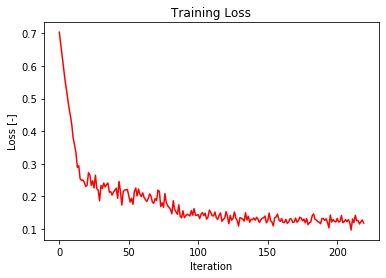

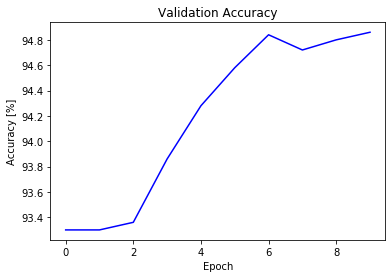

In [84]:
epochs = 10
learning_rate = 0.0005

## Network dimensions
D_in = embeddings_dim
n_hidden_1 = 128
n_hidden_2 = 32
D_out = 1
batch_size = 2048
reg_lambda = 0.0005
momentum_coef = 0.9
dropout_percent = 0.0

## Load data
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset), shuffle=False)

## Initialize model
net = Net(D_in, max_length, n_hidden_1,n_hidden_2, D_out, p = dropout_percent)
net.apply(weights_init)


optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = reg_lambda)
criterion = nn.BCELoss()

## Train the model
loss_accuracy = train_model(training_dataset, net, criterion, train_loader, validation_loader, optimizer, epochs=epochs)


## Plots
fig = plt.figure(1)
plt.plot(loss_accuracy['training_loss'], color="red")
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss [-]")

fig = plt.figure(2)
plt.plot(loss_accuracy['validation_accuracy'], color="blue")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")

Epoch 1 / 10
Training loss: 0.12321428209543228 | Training accuracy: 95.28%
Validation accuracy: 94.66%
Epoch 2 / 10
Training loss: 0.10415437072515488 | Training accuracy: 95.50%
Validation accuracy: 94.96%
Epoch 3 / 10
Training loss: 0.10843133181333542 | Training accuracy: 95.52%
Validation accuracy: 94.96%
Epoch 4 / 10
Training loss: 0.10625521838665009 | Training accuracy: 95.53%
Validation accuracy: 94.88%
Epoch 5 / 10
Training loss: 0.10747064650058746 | Training accuracy: 95.49%
Validation accuracy: 94.94%
Epoch 6 / 10
Training loss: 0.10736681520938873 | Training accuracy: 95.62%
Validation accuracy: 94.84%
Epoch 7 / 10
Training loss: 0.11677205562591553 | Training accuracy: 95.64%
Validation accuracy: 94.80%
Epoch 8 / 10
Training loss: 0.09911634773015976 | Training accuracy: 95.66%
Validation accuracy: 94.82%
Epoch 9 / 10
Training loss: 0.12704245746135712 | Training accuracy: 95.69%
Validation accuracy: 94.76%
Epoch 10 / 10
Training loss: 0.11741974204778671 | Training accu

Text(0, 0.5, 'Accuracy [%]')

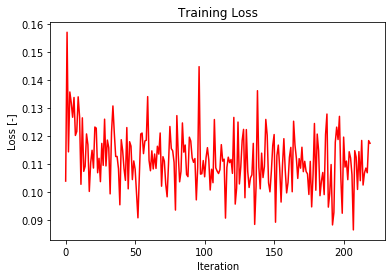

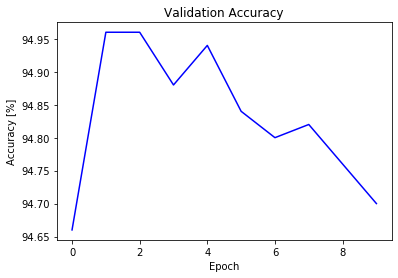

In [86]:
epochs = 10
learning_rate = 0.0005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = reg_lambda)
loss_accuracy = train_model(training_dataset, net, criterion, train_loader, validation_loader, optimizer, epochs=epochs)

## Plots
fig = plt.figure(1)
plt.plot(loss_accuracy['training_loss'], color="red")
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss [-]")

fig = plt.figure(2)
plt.plot(loss_accuracy['validation_accuracy'], color="blue")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")

In [2]:
def Plot_Confusion_Matrix(con_mat):
    
    plt.title("Confusion Matrix", fontsize=26)
    sns.set(font_scale=2.5)
    ax = sns.heatmap(con_mat, annot=True, fmt='g', annot_kws={"size":16}, xticklabels=["Negative", "Insincere"], yticklabels=["Negative", "Insincere"], 
               cmap="YlGnBu")
    ax.invert_yaxis()
    ax.invert_xaxis()
    plt.xlabel("Prediction", fontsize=16)
    plt.ylabel("True Label", fontsize=16)
    
    # Adjust height of heatmap because of a bug in matplotlib
    b, t = plt.ylim()
    ax.set_ylim(b-0.5, t+0.5)

In [3]:
net.eval()

x = Variable(torch.LongTensor(np.array(validation_sequences_padded)))

pred = net(x)
predicted_labels = np.where(pred > 0.5, 1, 0)
testing_labels = np.array(validation['target'])
accuracy = accuracy_score(testing_labels, predicted_labels)
precision = precision_score(testing_labels, predicted_labels)
recall = recall_score(testing_labels, predicted_labels)
f1 = f1_score(testing_labels, predicted_labels)

print('The validation accuracy is {:.2f}%'.format(accuracy*100))
print('The validation precision is {:.2f}'.format(precision))
print('The validation recall is {:.2f}'.format(recall))
print('The validation f1 score is {:.2f}'.format(f1))

NameError: name 'net' is not defined

In [1]:
con_mat = confusion_matrix(testing_labels, predicted_labels)
#con_mat = confusion_matrix([0, 1, 1, 0], [1, 1, 1, 0])
Plot_Confusion_Matrix(con_mat)
print(con_mat)

NameError: name 'confusion_matrix' is not defined

In [ ]:
print(train['question_text'].iloc[7291])
print(train_sequences_padded[7291])
#print(word_index['adventurous'])
print(train['target'][7291])

In [ ]:
#weight = torch.FloatTensor(embeddings_matrix)
#embeds = nn.Embedding.from_pretrained(weight)
#x = torch.LongTensor(train_sequences_padded[0])

In [ ]:
#print(embeds(x)[3])

In [ ]:
#embeddings_matrix[834]

In [3]:
np.array([5,1,2])

array([5, 1, 2])